In [ ]:
#|default_exp utils

# Extracting RGB values

> A bit of image processing 

## Extracting color patches 

Let's see if we can open the TIF and extract the RGB values for each color patch.  

In [ ]:
from colorchecker2cielab import extract_color_patches

In [ ]:
tif_file = '/home/frank/Work/DATA/colorchecker2cielab-data/sk-C-1833_135MB.tif'

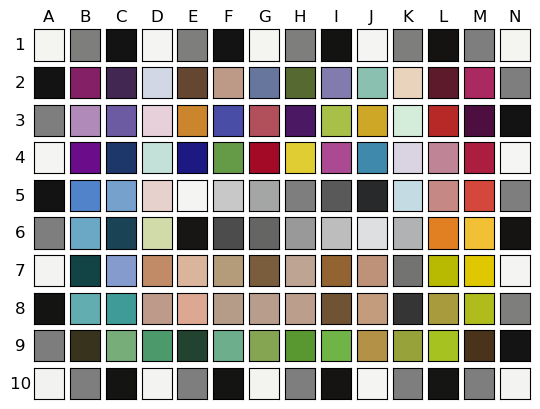

In [ ]:
rectangles, RGBs = extract_color_patches(tif_file)

In [ ]:
RGBs

,R,G,B
A1,0.955448,0.957560,0.941383
B1,0.492653,0.494630,0.491376
C1,0.079232,0.076354,0.075660
D1,0.958493,0.961770,0.947223
E1,0.492466,0.494535,0.491158
...,...,...,...
J10,0.955527,0.959005,0.947354
K10,0.491213,0.493347,0.490840
L10,0.082601,0.080506,0.075738
M10,0.491507,0.493843,0.491844


In [ ]:
#|export 

import skimage as sk
import matplotlib.pyplot as plt
import numpy as np 
import scipy.signal as ssg
import colour 
import pandas as pd 

In [ ]:
#|export 

def extract_color_patches(tif_file, nrows=10, ncols=14, make_plot=True): 

    # STEP 1: Read tif file and convert to float64  
    im_16bit = sk.io.imread(tif_file)
    im = sk.util.img_as_float64(im_16bit)
    
    # STEP 2: Convert to gray scale 
    im_grey = im.mean(axis=2)
    
    hist, bins = np.histogram(im_grey.flatten(), bins=200)
    bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2 
    
    # STEP 3: determine histogram based threshold for white patches 
    peak_idxs = ssg.find_peaks(hist)[0]
    grey, white = bin_centers[peak_idxs][-2:]
    thresh = (grey + white) / 2 
    
    # STEP 4: label white connected regions 
    is_white_regions = im_grey > thresh
    labeled_regions =sk.measure.label(is_white_regions)
    
    # STEP 5: select 15 largest white patch regions and create mask 
    region_props = sk.measure.regionprops_table(labeled_regions, properties=['label', 'area'])
    areas = region_props['area'] 
    labels = region_props['label']
    
    min_patch_area = 0.9 * areas.max() 
    is_white_patch = areas > min_patch_area 
    white_patch_areas = areas[is_white_patch]
    
    assert len(white_patch_areas) == 15, 'Could not locate 15 white patch regions in image' 
    
    white_patches_mask = np.zeros_like(im_grey, dtype=int)
    for l in labels[is_white_patch]: 
        white_patches_mask[labeled_regions == l] = 1
    
    # STEP 6: locate white corner patches 
    labeled_patches = sk.measure.label(white_patches_mask)
    patch_props = sk.measure.regionprops_table(labeled_patches, properties=['label', 'centroid', 'bbox'])
    cy = patch_props['centroid-0']
    cx = patch_props['centroid-1'] 
    cxy = np.c_[cx, cy]
    
    # canvas bounding box (clockwise)
    bx0, bx1 = np.min(cx), np.max(cx)
    by0, by1 = np.min(cy), np.max(cy)
    canvas_bbox = np.array([[bx0, by0], [bx1, by0], [bx1, by1], [bx0, by1]])  
    
    # locate corner patch centroids 
    cc_idxs = [] 
    for b_xy in canvas_bbox: 
        dist = np.linalg.norm(cxy - b_xy, axis=1) 
        i_nn = np.argmin(dist) 
        cc_idxs.append(i_nn) 
    
    corners_xy = cxy[cc_idxs]
    
    # STEP 7: also determine patch core radius 
    min_row = patch_props['bbox-0']
    min_col= patch_props['bbox-1']
    max_row = patch_props['bbox-2']
    max_col = patch_props['bbox-3']
    
    height = np.min(max_row - min_row)
    width = np.min(max_col - min_col)
    delta = np.min([width, height])
    radius = int(0.4 * delta)
    
    # STEP 8: build patch grid 
    top_left, top_right, bottom_right, bottom_left = corners_xy
    
    left = _interpoints(top_left, bottom_left, nrows)
    right = _interpoints(top_right, bottom_right, nrows)
    
    grid_xy = []
    
    for xy0, xy1 in zip(left, right): 
        xy_pts = _interpoints(xy0, xy1, ncols) 
        grid_xy.append(xy_pts)
    
    grid_xy = np.array(grid_xy)
    grid_list = grid_xy.reshape([nrows * ncols, 2]) 
    
    rectangles = _make_rectangles(grid_list, radius)  
    
    patch_RGBs = _extract_RGBs(im, rectangles)
    
    if make_plot:  
        _plot(rectangles, patch_RGBs) 

    # create dataframe from patch_RGBs array  
    A1_to_N10 = [] 
    for n in range(1, 11): 
        for c in 'ABCDEFGHIJKLMN': 
            A1_to_N10.append(f'{c}{n}') 
            
    RGBs_df = pd.DataFrame(patch_RGBs, index=A1_to_N10, columns=['R', 'G', 'B']) 
    
    return rectangles, RGBs_df

def _interpoints(xy0, xy1, n_pts): 
    
    x0, y0 = xy0
    x1, y1 = xy1 

    x_pts = np.linspace(x0, x1, n_pts)
    y_pts = np.linspace(y0, y1, n_pts) 
    xy_pts = np.c_[x_pts, y_pts]

    return xy_pts 

def _make_rectangles(grid_list, radius, ax=None): 

    n = len(grid_list)
    w = radius * 2 
    xy0_list = np.round(grid_list).astype(int) - radius 
    widths = np.ones(n, dtype=int) * w 
    
    rectangles = np.c_[xy0_list, widths]
    
    # add rectangles to figure axis 
    if ax is not None: 
        for xy0 in xy0_list: 
            ax.add_patch(plt.Rectangle(xy0, w, w, edgecolor='r', facecolor='none'))
            
        
    return rectangles

def _extract_RGBs(im, rectangles): 
    '''Extract mean RGB values for patch rectangles. '''

    patch_images = [im[y0:y0+w+1, x0:x0+w+1] for x0, y0, w in rectangles] 
    patch_RGBs = np.array([p.reshape(-1, 3).mean(axis=0).tolist() for p in patch_images]) 
    
    return patch_RGBs

def _plot(rectangles, patch_RGBs):
    '''Create plot with color patches. '''

    fig, axs = plt.subplots(nrows=10, ncols=14)

    axs = axs.flatten()
    
    for i, rgb in enumerate(patch_RGBs): 
        axs[i].set_facecolor(rgb)
        axs[i].set_xticks([])
        axs[i].set_yticks([]) 
    
    letters = 'ABCDEFGHIJKLMN'
    
    for i in range(14): 
        axs[i].set_title(letters[i]) 
    
    for j in range(10): 
        axs[j*14].set_ylabel(f'{j+1}   ', rotation=0, loc='center', fontsize=12, va='center') 
